In [3]:
import torch
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
tar_path = "/content/drive/MyDrive/datasets/UrbanSound8K.tar.gz"

extract_path = "/content/UrbanSound8K/UrbanSound8K"

for root, dirs, files in os.walk(extract_path):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files}")
    print()

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

!tar -xzf {tar_path} -C {extract_path}

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [5]:
metadata = pd.read_csv('/content/UrbanSound8K/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv')
print("Dataset Metadata:")
print(metadata.head())

Dataset Metadata:
      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [23]:
print("\nClass Distribution:")
print(metadata['class'].value_counts())


Class Distribution:
class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64


In [25]:
print("\nAudio Characteristics:")
print(f"Total samples: {len(metadata)}")
print(f"Sample rates: {metadata['fsID'].unique()}")
print(f"Duration stats:\n{metadata['end']-metadata['start']}.describe()")


Audio Characteristics:
Total samples: 8732
Sample rates: [100032 100263 100648 ...  99500  99710  99812]
Duration stats:
0       0.317551
1       4.000000
2       4.000000
3       4.000000
4       4.000000
          ...   
8727    4.000000
8728    2.142545
8729    3.505983
8730    2.532098
8731    2.532099
Length: 8732, dtype: float64.describe()


In [22]:
label_encoder = LabelEncoder()
metadata['encoded_label'] = label_encoder.fit_transform(metadata['class'])

In [26]:
def create_windows(window_type, N, device):
    n = torch.arange(N, device=device)
    if window_type == 'hann':
        return torch.hann_window(N, device=device)
    elif window_type == 'hamming':
        return torch.hamming_window(N, device=device)
    elif window_type == 'rectangular':
        return torch.ones(N, device=device)
    else:
        raise ValueError("Unknown window type")

In [29]:
class AudioProcessor:
    def __init__(self, sr=22050, n_fft=2048, hop_length=512, device=None):
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.n_mels = 128
        self.mel_scale = torchaudio.transforms.MelScale(
            n_mels=self.n_mels, sample_rate=self.sr, n_stft=n_fft // 2 + 1
        ).to(self.device)

    def process_audio(self, audio_path, window_type):
        waveform, orig_sr = torchaudio.load(audio_path)
        waveform = waveform.mean(dim=0, keepdim=True)

        if orig_sr != self.sr:
            resampler = torchaudio.transforms.Resample(orig_sr, self.sr)
            waveform = resampler(waveform)

        waveform = waveform.to(self.device)
        window = create_windows(window_type, self.n_fft, self.device)

        stft = torch.stft(waveform, n_fft=self.n_fft, hop_length=self.hop_length,
                          window=window, return_complex=True)
        spectrogram = torch.abs(stft)**2
        mel_spec = self.mel_scale(spectrogram)
        log_mel = torch.log(mel_spec + 1e-9)

        return log_mel.cpu().numpy()

In [30]:
class UrbanSoundDataset(Dataset):
    def __init__(self, metadata, window_type):
        self.metadata = metadata
        self.window_type = window_type
        self.processor = AudioProcessor()
        self.label_encoder = LabelEncoder().fit(metadata['class'])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        file_path = f"{extract_path}/UrbanSound8K/audio/fold{row['fold']}/{row['slice_file_name']}"
        log_mel = self.processor.process_audio(file_path, self.window_type)
        log_mel = torch.tensor(log_mel).mean(dim=0)
        features = torch.cat([log_mel.mean(dim=-1), log_mel.std(dim=-1), log_mel.max(dim=-1).values])
        label = self.label_encoder.transform([row['class']])[0]
        return features.float(), label

In [44]:
def generate_spectrogram(audio_path, window_type):
    processor = AudioProcessor()
    spec = processor.process_audio(audio_path, window_type)
    spec = np.clip(spec, 1e-9, None)
    return np.log10(spec)

def visualize_class_spectrograms(metadata):
    windows = ['hann', 'hamming', 'rectangular']

    class_samples = metadata.groupby('class').apply(lambda x: x.sample(1)).reset_index(drop=True)

    for _, row in class_samples.iterrows():
        file_path = f"{extract_path}/UrbanSound8K/audio/fold{row['fold']}/{row['slice_file_name']}"

        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Spectrograms for {row['class']} ({row['slice_file_name']})")

        for i, window in enumerate(windows, 1):
            spec = generate_spectrogram(file_path, window)
            plt.subplot(1, 3, i)
            plt.imshow(spec[0], aspect='auto', origin='lower', cmap='viridis')
            plt.title(f"{window.capitalize()} Window")
            plt.colorbar(label='Log Magnitude')

        plt.tight_layout()
        plt.show()

<ipython-input-44-7ac7d5f0d13b>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_samples = metadata.groupby('class').apply(lambda x: x.sample(1)).reset_index(drop=True)


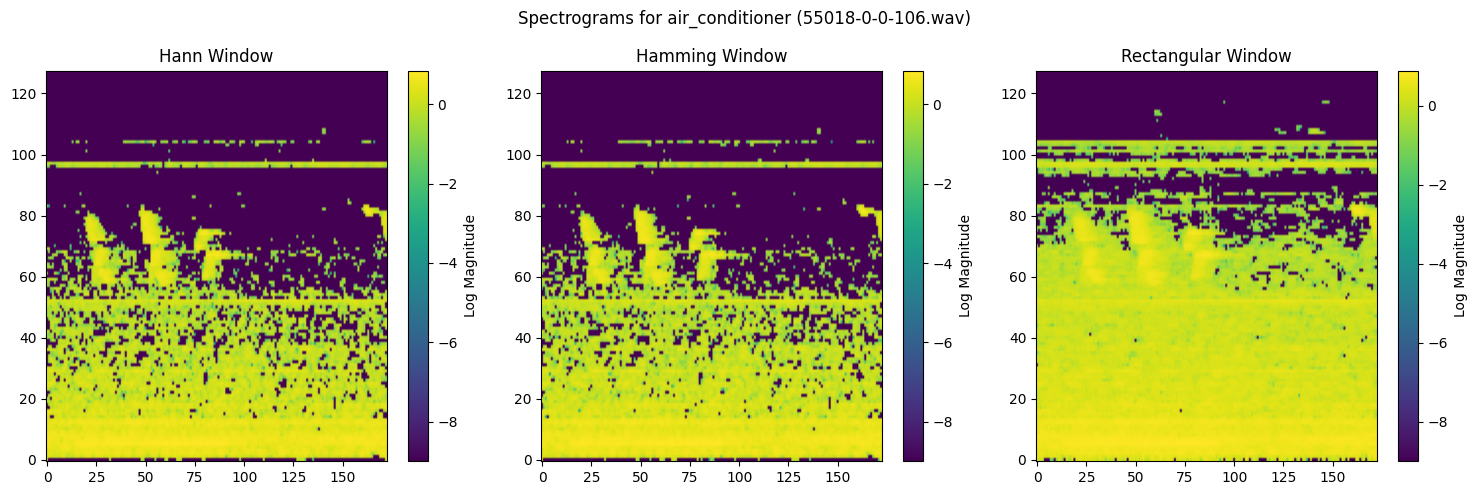

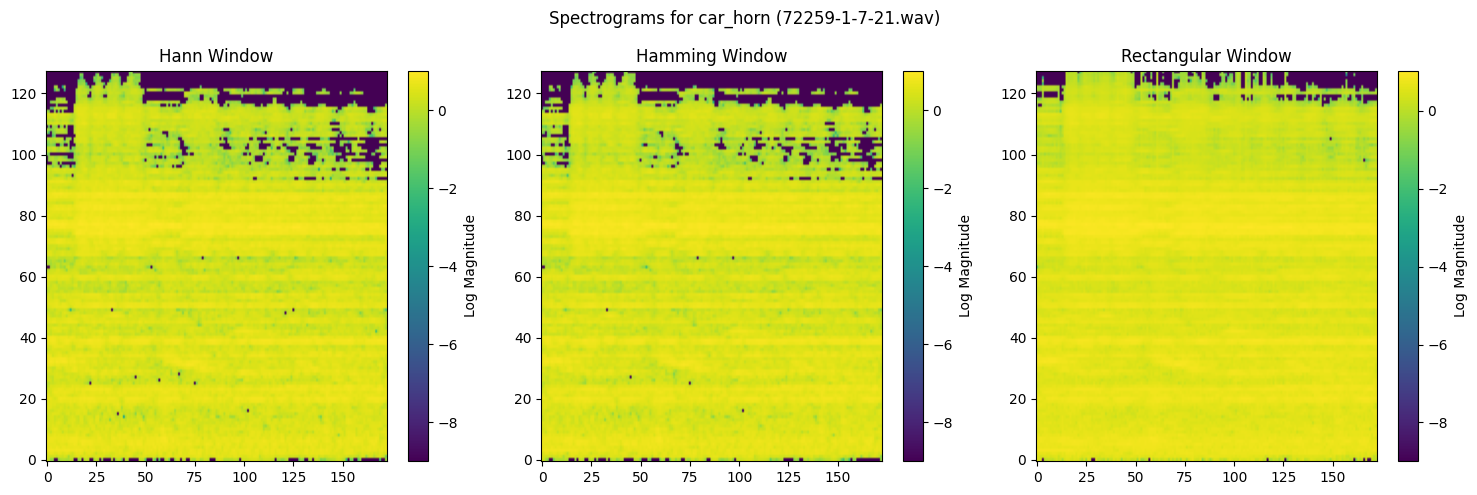

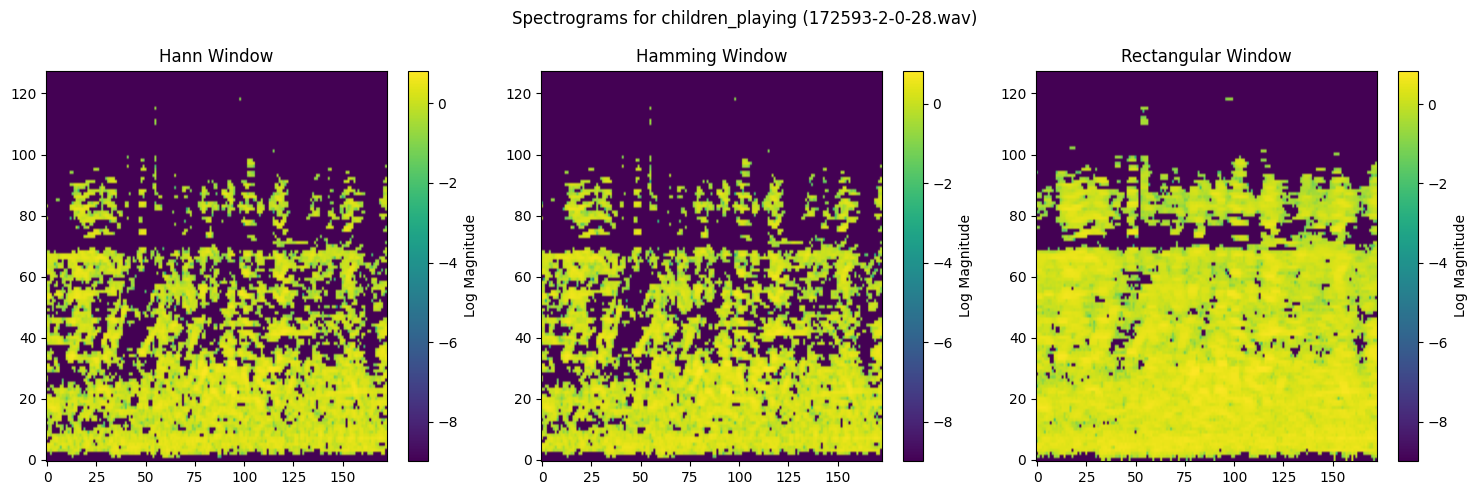

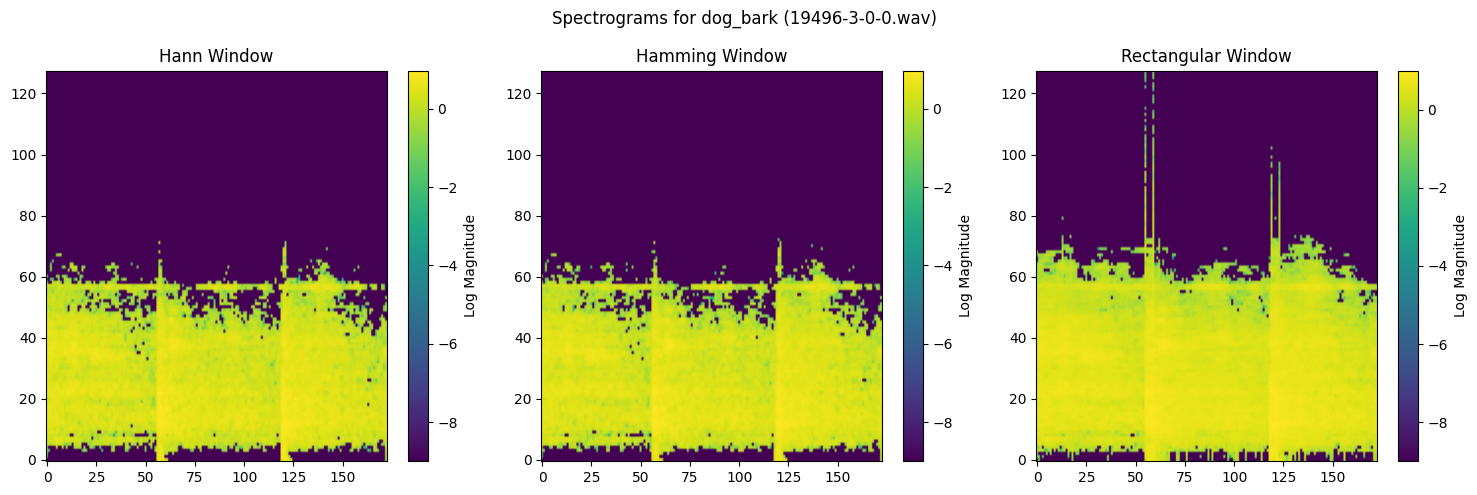

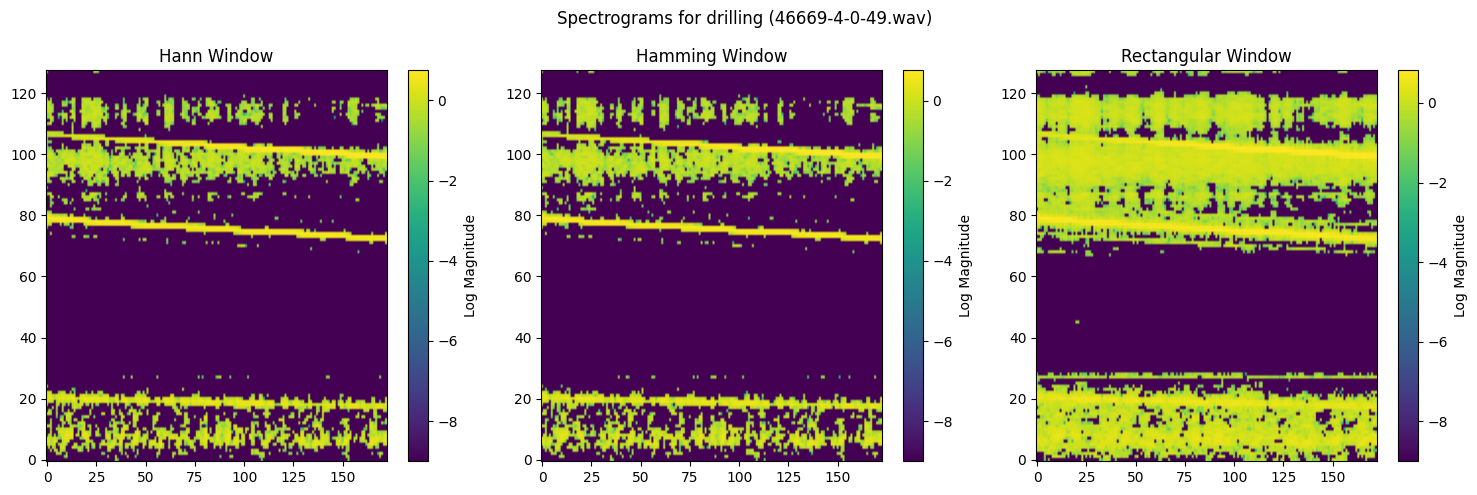

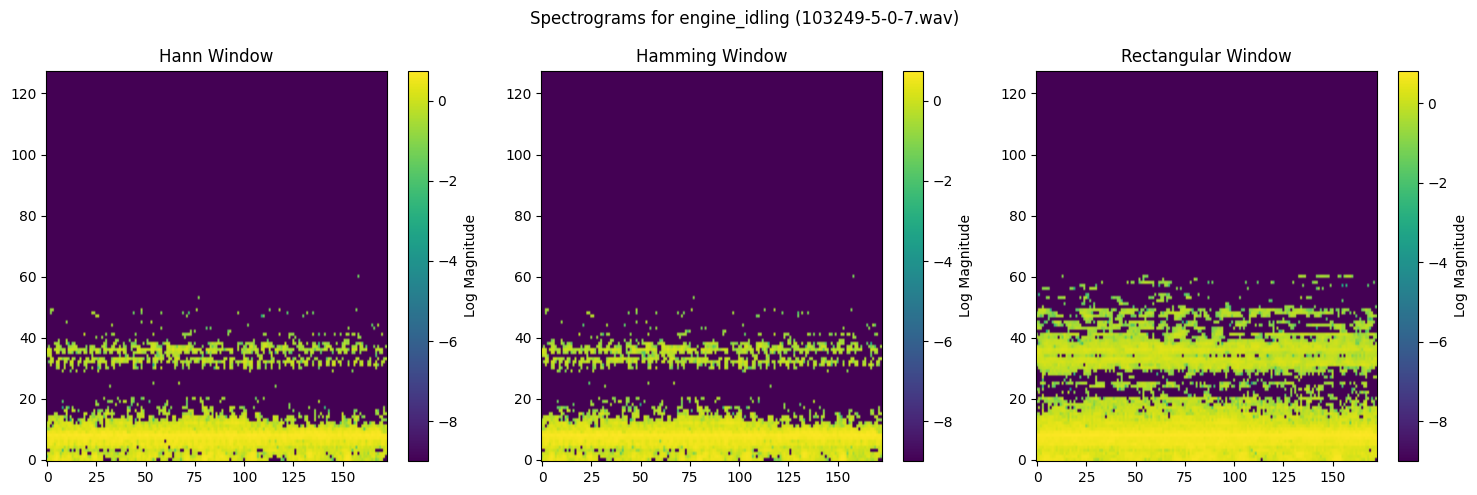

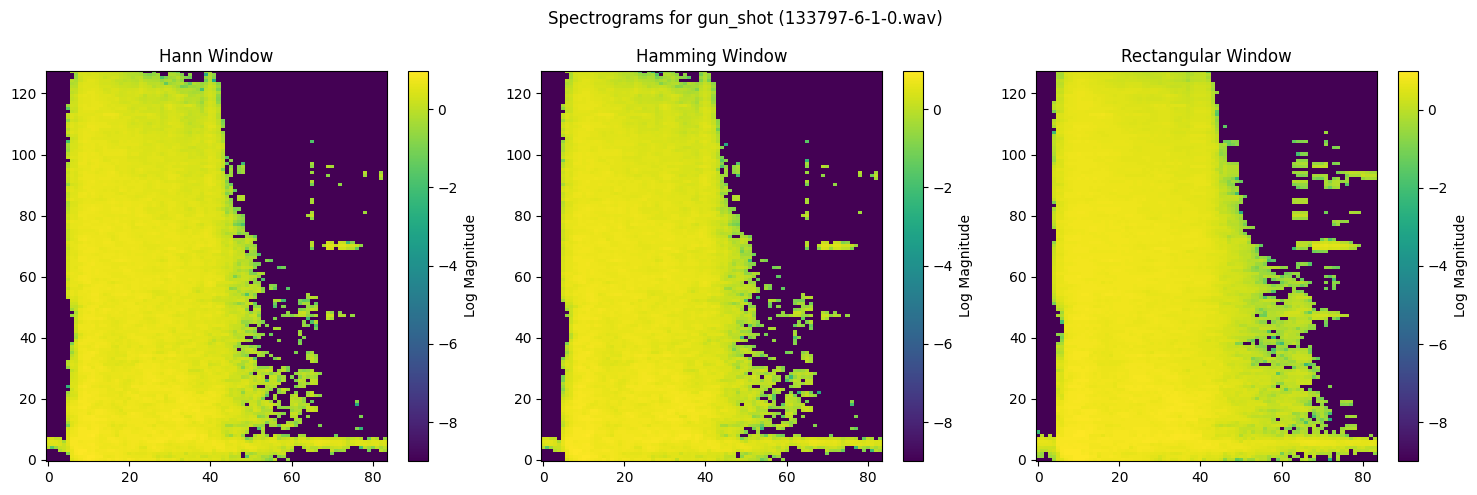

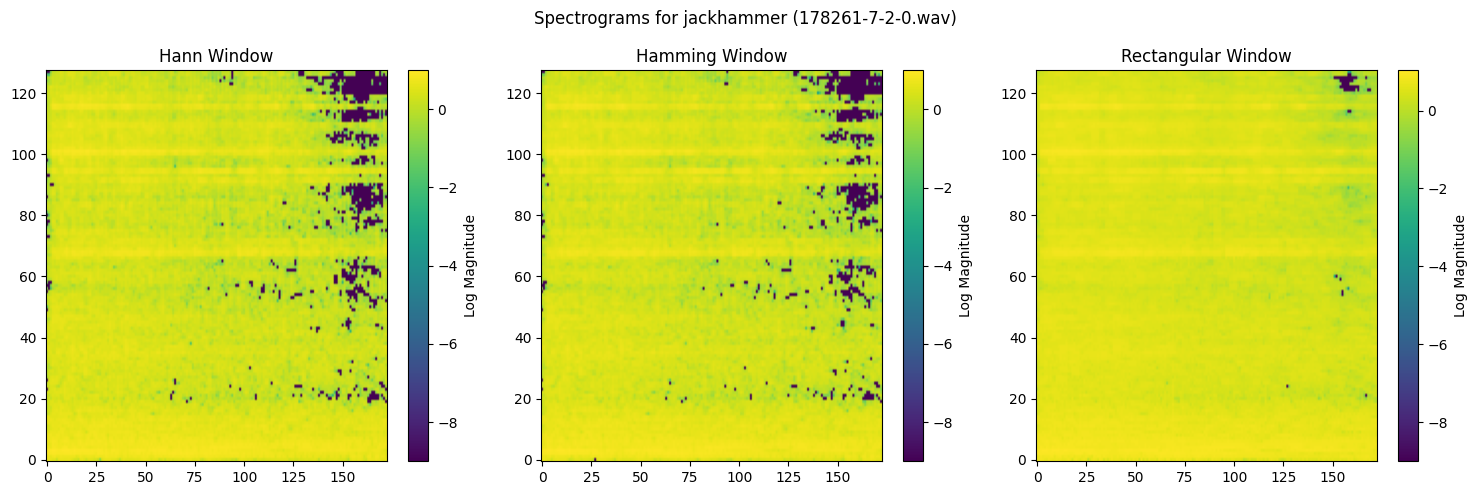

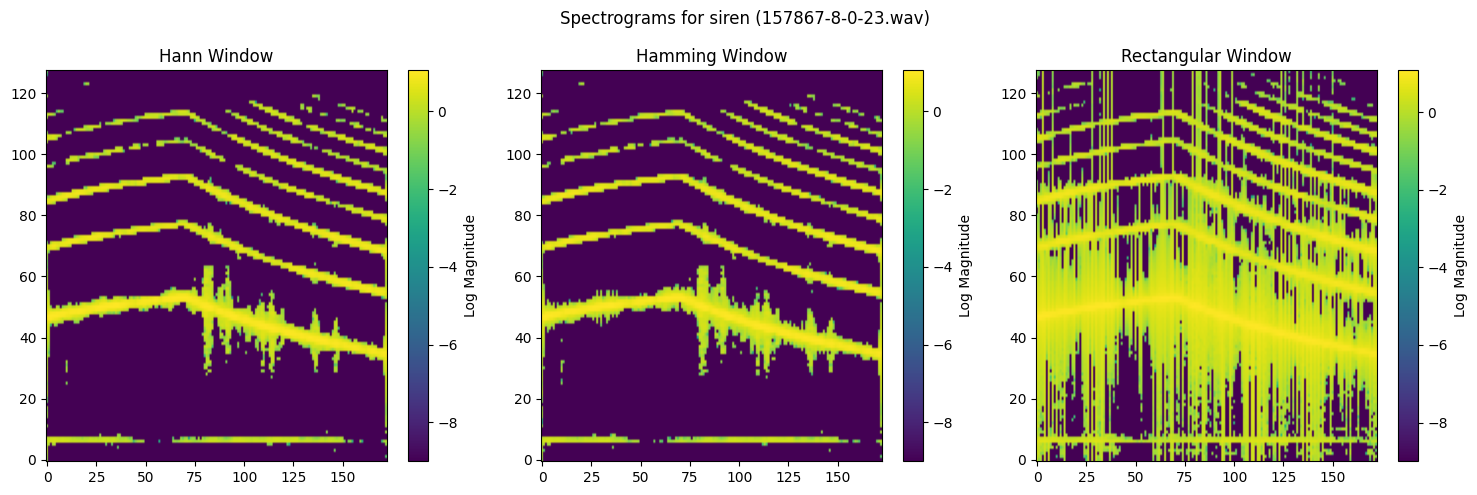

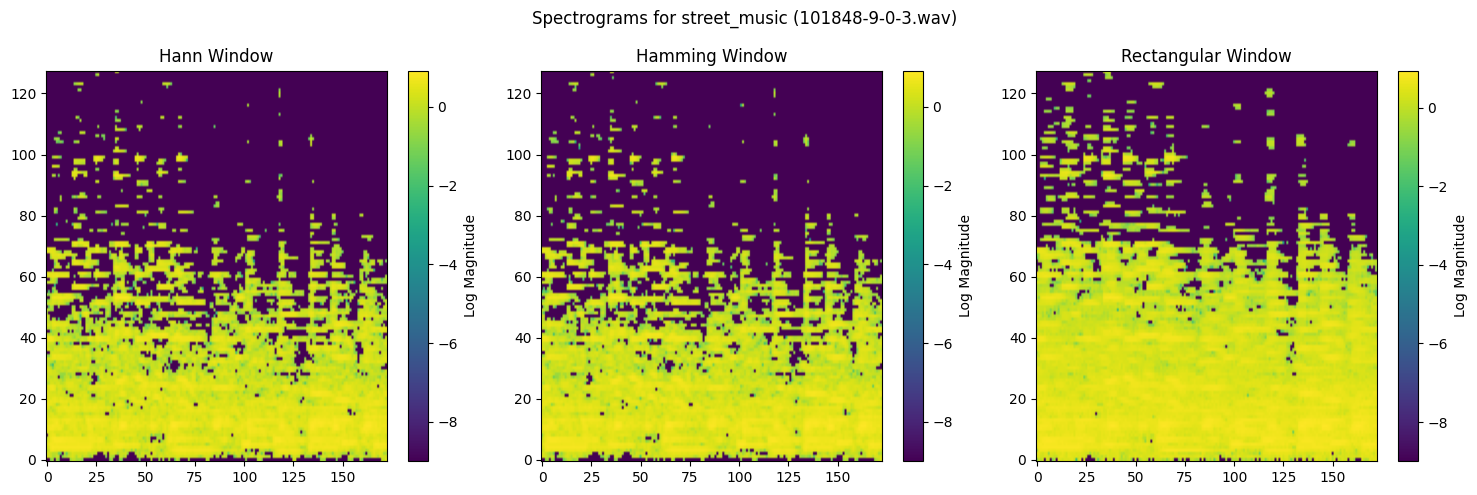

In [45]:
visualize_class_spectrograms(metadata)

In [32]:
class AudioClassifier(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_size, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [49]:
def train_evaluate(window_type, num_epochs=10):
    train_df, test_df = train_test_split(metadata, test_size=0.2, stratify=metadata['class'])
    train_dataset = UrbanSoundDataset(train_df, window_type)
    test_dataset = UrbanSoundDataset(test_df, window_type)

    input_size = 384  # 128 mel bands * 3 statistics
    num_classes = 10
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = AudioClassifier(input_size, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    print(f"Training with {window_type} window:")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

    test_loader = DataLoader(test_dataset, batch_size=64)
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            outputs = model(features)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Final Accuracy with {window_type} window: {accuracy:.4f}\n")
    return accuracy

In [50]:
window_types = ['hann', 'hamming', 'rectangular']
results = {window: train_evaluate(window) for window in window_types}

print("\nFinal Results:")
for window, acc in results.items():
    print(f"{window:12} - Accuracy: {acc:.4f}")


Training with hann window:
Epoch 1/10 - Loss: 1.4316
Epoch 2/10 - Loss: 1.0408
Epoch 3/10 - Loss: 0.8911
Epoch 4/10 - Loss: 0.8271
Epoch 5/10 - Loss: 0.7185
Epoch 6/10 - Loss: 0.6541
Epoch 7/10 - Loss: 0.6345
Epoch 8/10 - Loss: 0.5613
Epoch 9/10 - Loss: 0.5421
Epoch 10/10 - Loss: 0.4927
Final Accuracy with hann window: 0.8231

Training with hamming window:
Epoch 1/10 - Loss: 1.4430
Epoch 2/10 - Loss: 1.0578
Epoch 3/10 - Loss: 0.9117
Epoch 4/10 - Loss: 0.8007
Epoch 5/10 - Loss: 0.7574
Epoch 6/10 - Loss: 0.6624
Epoch 7/10 - Loss: 0.6223
Epoch 8/10 - Loss: 0.5990
Epoch 9/10 - Loss: 0.5498
Epoch 10/10 - Loss: 0.5043
Final Accuracy with hamming window: 0.8426

Training with rectangular window:
Epoch 1/10 - Loss: 1.4398
Epoch 2/10 - Loss: 1.1459
Epoch 3/10 - Loss: 0.9682
Epoch 4/10 - Loss: 0.8910
Epoch 5/10 - Loss: 0.8111
Epoch 6/10 - Loss: 0.7650
Epoch 7/10 - Loss: 0.7144
Epoch 8/10 - Loss: 0.6955
Epoch 9/10 - Loss: 0.6297
Epoch 10/10 - Loss: 0.6128
Final Accuracy with rectangular window: 0